In [1]:
import os
import csv 
import json
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from pylab import savefig
from datetime import datetime
import pandas_profiling
import sklearn
import xgboost as xgb

from scipy.stats import uniform
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


def write_log_header(working_df, data_filename, session_log) :
    """save summary information to results file
    """

    cols_with_nulls = working_df.columns[df.isnull().any()]
    with open(session_log, 'w+') as f:   
        f.write('\nsklearn version: ' + sklearn.__version__)
        f.write('\npandas version: ' + pd.__version__)
        f.write('\nnumpy version: ' + np.__version__)
        f.write('\nPandas Profile version: ' + pandas_profiling.__version__)

        f.write('\n\nData file ' + data_filename + '\n\n')
        f.write('Shape: ' + str(working_df.shape) + '\n')
        f.write('Columns with null data: \n')
        if len(cols_with_nulls) == 0:
            f.write('None\n')
        else:
            for col in cols_with_nulls:
                f.write(col + '\n')

        cols = sorted(working_df.columns)
        f.write('\nOriginal columns in data file: \n')
        for item in cols:
            f.write(item + '\n')            


def update_columns(working_df, col_info_filename, session_log):
    """ update column names to readable versions
        data is read as categorical, update type for 4 numeric columns
    """
    #these are numerical columns and are interpreted as such
    working_df['MOD10FWK'] = pd.to_numeric(working_df['MOD10FWK'])
    working_df['VIG10FWK'] = pd.to_numeric(working_df['VIG10FWK'])
    working_df['STRONGFWK'] = pd.to_numeric(working_df['STRONGFWK'])
    
    #update column names 
    info_dict = pd.read_csv(col_info_filename, index_col=0, squeeze=True, header=None).to_dict()
    working_df.rename(columns=info_dict, inplace=True)

    cols = sorted(working_df.columns)
    
    with open(session_log, 'a') as f: 
        f.write('\nrenamed columns in data file: \n')
        for item in cols:
            f.write(item + '\n')  

    return working_df


def drop_columns(working_df, cols_to_drop_filename, session_log):
    """drop columns with high percentage of unusable data and/or high correlation
       to other non-target features 
    """
    
    with open(session_log, 'a') as f:   
        f.write('\nShape before dropping columns\n' + str(working_df.shape))
   
    #read columns from file
    with open(cols_to_drop_filename, 'r') as f_cols:
        reader = csv.reader(f_cols)
        cols_to_drop = [r[0] for r in reader]
    
    #drop columns
    working_df.drop(columns=cols_to_drop, axis=1, inplace=True)
    
    with open(session_log, 'a') as f:   
        f.write('\nShape after dropping columns\n' + str(working_df.shape))
    
        cols = sorted(working_df.columns)
        f.write('\nFinal columns in data file: \n')
        for item in cols:
            f.write(item + '\n')            

    return working_df


def drop_invalid_target_rows(working_df, session_log):
    """update dataset to only use rows with target = no (1) or yes (2)
    """
    
    with open(session_log, 'a') as f:   
        f.write('\nShape before deleting invalid target rows\n' + str(working_df.shape))
   
    new_df = working_df[(working_df['HYPERTENEV'] !='0') & \
                        (working_df['HYPERTENEV'] !='7') & \
                        (working_df['HYPERTENEV'] !='9') & \
                        (working_df['HYPERTENEV'] !='8') ]
   
    with open(session_log, 'a') as f:   
        f.write('\nShape after deleting invalid target rows\n' + str(new_df.shape))
        f.write('\nhypertension value counts:\n ')
        counts = new_df['HYPERTENEV'].value_counts()
        f.write('\nindex: ' + str(counts.index.tolist()))
        f.write('\nvalues: ' + str(counts.values.tolist()))
            
    return new_df

def drop_missing_data_rows(working_df, session_log, after_rename = False):
    with open(session_log, 'a') as f:   
        f.write('\nShape before deleting missing data rows\n' + str(working_df.shape))
    
    if after_rename:
        new_df = working_df[(working_df['Ever had chickenpox'] !='0') & \
                            (working_df['Age first smoked fairly regularly'] !='0') & \
                            (working_df['Kind of usual place for medical care'] !='0')]
        counts = new_df['Ever told had hypertension'].value_counts()
    else:
        new_df = working_df[(working_df['CPOXEV'] !='0') & \
                            (working_df['SMOKAGEREG'] !='0') & \
                            (working_df['TYPPLSICK'] !='0')]
        counts = new_df['HYPERTENEV'].value_counts()
    
    with open(session_log, 'a') as f:   
        f.write('\nShape after deleting missing data rows\n' + str(new_df.shape))
        f.write('\nhypertension value counts:\n ')
        print(counts)
        f.write('\nindex: ' + str(counts.index.tolist()))
        f.write('\nvalues: ' + str(counts.values.tolist()))
            
    return new_df

def run_Pandas_Profiling(working_df, session_log, break_into_sections = False, num_cols=5):
    """Run Pandas_Profiling 
    """
    t0 = datetime.now()
    start_col_idx = 0
    end_col_idx = num_cols
    cols = list(working_df.columns)
    total_cols = len(cols)
    
    with open(session_log, 'a') as f:   
        f.write('\n\nrun_Pandas_Profiling Begin\n')
    
    if break_into_sections:
        while end_col_idx <= total_cols:
            #slice the column list by the given num_cols
            cols_by_section = cols[start_col_idx:end_col_idx] 

            #make sure the target variable is in the heat maps
            if 'Ever told had hypertension' not in cols_by_section:
                cols_by_section.append('Ever told had hypertension')

            #create a dataset with only the selected columns
            df_to_profile = working_df.loc[:, cols_by_section]

            with open(session_log, 'a') as f:   
               f.write('\nProfiling : ' + str(df_to_profile.columns) + '\n')
                
            #run the profile
            profile = df_to_profile.profile_report(title = 'Pandas Profiling Report')
            profile.to_file(output_file = timestamp + '_' + str(start_col_idx) + "output.html")

            #update the indicies for the next slice or the end slice
            start_col_idx = end_col_idx 
            if (end_col_idx + num_cols > total_cols) and (total_cols % num_cols > 0):
                end_col_idx += total_cols % num_cols
            else:
                end_col_idx += num_cols
    else:
        #run the profile on all of the columns
        profile = working_df.profile_report(title='Pandas Profiling Report')
        profile.to_file(output_file= timestamp + '_' + str(start_col_idx) + "output.html")

    total_time = datetime.now() - t0
    with open(session_log, 'a') as f:   
        f.write('\nrun_Pandas_Profiling End.  Duration: ' + str(total_time) + '\n')


def run_model(classifier, X_train_data, X_test_data, y_train_data, y_test_data, tuning_model='None', hyperparams={}):
    """fit the algorithm to training data
       predict using testing data
       print the confusion matrix & classification report
       return F1 score for the positive class
    """
    t0 = datetime.now()

    #if performing hyperparameter tuning & cross validation, use those estimators to fit
    #otherwise use the basic classifier
    if tuning_model == 'Grid':
        estimator = GridSearchCV(classifier, hyperparams, cv=5, verbose=0)
    elif tuning_model == 'Random':
        estimator = RandomizedSearchCV(classifier, hyperparams, n_iter=15, cv=5, verbose=0, random_state=42)
    else:
        estimator = classifier
    
    # Fit the classifier to the data
    model = estimator.fit(X_train_data, y_train_data)

    if tuning_model != 'None':
        print('Best parameters: ', sorted(model.best_params_.items()))
        
    # Predict the labels for the training data X
    y_pred = model.predict(X_test_data)
    
    # Print the confusion matrix and classification report
    print('Confusion maxtrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    
    print('Run time: ', datetime.now() - t0)
    # Return the F1 score for the positive class to use for ranking models
    return sklearn.metrics.f1_score(y_test, y_pred, labels=None, pos_label='2', sample_weight=None)
    

def tally_results(all_results):
    """ determine if latest results are better than all_results
    """
    latest = list(all_results.values())[-1]
    best = max(all_results.values())
    if latest >= best:
        print('Improvement over prior models!')
    else:
        print('No improvement over prior models. Best model so far: {}, {:.2%}'.format( 
          max(model_results, key=model_results.get), best))
    
    
def plot_results(results_dict):
    """ plot bar chart of results """

    # create a list of tuples sorted by key
    lists = sorted(results_dict.items()) 
    # unpack tuples
    x, y = zip(*lists) 
    plt.barh(x, y)
    plt.title('F1 score results')
    plt.show()
    


def XGBoost_classifer(X_train_data, X_test_data, y_train_data, y_test_data, colnames, session_log):
    """Use XGBoost to predict target
        Params defined from hyperparameter tuning
    """
    print("XGBoost_classifer")

    mod = xgb.XGBClassifier(
        learning_rate =0.1,   
        n_estimators=151, 
        max_depth=5,
        min_child_weight=1,  #default
        gamma=1,
        subsample=0.8,
        colsample_bytree=0.6,
        objective= 'binary:logistic', # try hinge - make predictions of 0 or 1, rather than probabilities
        max_delta_step = 1, #tuning for imbalanced dataset where we care about the probability, not AUC
        seed=42) 

    mod.fit(X_train_data, y_train_data)
    y_pred = mod.predict(X_test_data)

    print('Confusion maxtrix: \n', confusion_matrix(y_test_data, y_pred))
    print('Classification report: \n', classification_report(y_test_data, y_pred))
    
    
    coefs = list(zip(colnames, mod.feature_importances_))
    coefs.sort(key=lambda tup: tup[1])
   
    with open(session_log, 'a') as f:   
        f.write('\nXGBoost_classifer\n')
        params = json.dumps(mod.get_params())
        f.write('\nParams' + params + '\n')
        f.write('\nFeature importances' + '\n')
        for col, value in coefs:
            f.write(str(value) + ':' + col + '\n')
        f.write(np.array2string(confusion_matrix(y_test_data, y_pred), separator=', '))
        f.write('\n')
    report = classification_report(y_test_data, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(session_log, mode='a')
    

def XGBoost_grid_search_cv(X_train_data, X_test_data, y_train_data, y_test_data, session_log):
    """
    Test various sets of hyperparameters, updating model with best values

    #Round 1:
    #hyperparameters = {'max_depth':range(3,10,2),'min_child_weight':range(1,6,2)}
    #Best params:  {'max_depth': 5, 'min_child_weight': 1}
    """

    #Round 2:
    #hyperparameters = {'gamma':[i/10.0 for i in range(0,5)]}
    #Best params:  {'gamma': 0.0} #however, better F1 values with gamma = 1

    #Round 3:
    #hyperparameters = {'subsample':[i/10.0 for i in range(6,10)],'colsample_bytree':[i/10.0 for i in range(6,10)]}
    #Best params:  {'colsample_bytree': 0.6, 'subsample': 0.8}

    #Round 4: 
    #hyperparameters = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]}
    #Best params:  {'reg_alpha': 0.001}
    #This produced no change in the results, so leaving it out

    print("XGBoost grid search")
    mod = xgb.XGBClassifier(
        learning_rate =0.1,   #more conservative and the default
        n_estimators=151,     #optimized # based on xgb.cv
        max_depth=5,
        min_child_weight=1,  #default
        gamma=1,
        subsample=0.8,
        colsample_bytree=0.6,
        #objective= 'binary:hinge', #make predictions of 0 or 1, rather than probabilities
        nthread=4,
        scale_pos_weight=1, #default
        max_delta_step = 1, #tuning for imbalanced dataset where we care about the probability, not AUC
        seed=27)

    
    # Create grid search using 5-fold cross validation
    print('grid search')
    clf = GridSearchCV(mod, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train_data, y_train_data)

    # View best hyperparameters
    print('Best n_estimator:', best_model.best_estimator_.get_params()['n_estimators'])
    print('Best learning rate:', best_model.best_estimator_.get_params()['learning_rate'])
    print('Best params: ', best_model.best_params_)
    df_results = best_model.cv_results_
    print('Results: ', df_results )
  
    y_pred = best_model.predict(X_test_data)

    print('Confusion maxtrix: \n', confusion_matrix(y_test, y_pred))
    print('Classification report: \n', classification_report(y_test, y_pred))
    
    
    with open(session_log, 'a') as f:   
        f.write('\nXGBoost_grid_search_sv\n')
        params = json.dumps(best_model.best_params_)
        f.write('\nBest params' + params + '\n')
        #f.write('\nResults' + best_model.cv_results_ + '\n')
        f.write(np.array2string(confusion_matrix(y_test_data, y_pred), separator=', '))
        f.write('\n')
        
    report = classification_report(y_test_data, y_pred, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df.to_csv(session_log, mode='a')


def xgb_cv(X_train_data, X_test_data, y_train_data, y_test_data, session_log, cv_folds=5, early_stopping_rounds=50):
    #use xgb cross validation to find optimal n_estimators
    #trains until cv error hasn't reduced by early_stopping_rounds
    
    #using DMatrix requires label to be [0, 1], in data 1=no, 2=yes
    y_train_data[y_train_data == '1'] = 0
    y_train_data[y_train_data == '2'] = 1
    y_test_data[y_test_data == '1'] = 0
    y_test_data[y_test_data == '2'] = 1

    xgb_param = {
    'learning_rate': 0.1, 
    'n_estimators' : 151,
    'max_depth':5,
    'min_child_weight':1,
    'gamma':1,
    'subsample': 0.8, 
    'colsample_bytree': 0.6, 
    'objective': 'binary:logistic',
    'max_delta_step' : 1, #tuning for imbalanced dataset where we care about the probability, not AUC 
    'seed':27, 
               } 

    
    #xgb_param = alg.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train_data, label=y_train_data)
    xgtest = xgb.DMatrix(X_test_data)

    #use error as metric for binary classification problem
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=xgb_param['n_estimators'], nfold=cv_folds,
        metrics=['error'], early_stopping_rounds=early_stopping_rounds)

    print('optimal n_estimators from xgb.cv : ', str(cvresult.shape[0]))

    #update the n_estimators returned from xgb.cv
    xgb_param['n_estimators'] = cvresult.shape[0]
    final_gb = xgb.train(xgb_param, xgtrain, num_boost_round = cvresult.shape[0])
    final_gb.params = xgb_param
    
    
    #get feature importances
    importances = final_gb.get_fscore()

    with open(session_log, 'a') as f:   
        f.write('\nXgb_cv\n')
        params = json.dumps(xgb_param)
        f.write('\nParams used in cv' + params + '\n')
        f.write('\noptimal n_estimators:' + str(cvresult.shape[0]) + '\n')
        fet_imp = json.dumps(importances)
        f.write('\nFeature importances ' + fet_imp + '\n')

    #Fit the algorithm on the data
    final_gb.fit(X_train_data, y_train_data, eval_metric='auc')

    #Predict on test set
    y_pred = final_gb.predict(xgtest) 

    #the predict function for XGBoost outputs probabilities by default and not actual class labels
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    
    print('\naccuracy_score  ', str(accuracy_score(y_pred, y_test)))
    
    cm = confusion_matrix(y_test_data, (y_pred>0.5))
    print(cm)

    # dump model with feature map
    final_gb.dump_model('dump.raw.txt', 'featmap.txt')   

    #print('Confusion maxtrix: \n', confusion_matrix(y_test, y_pred))
    #print('Classification report: \n', classification_report(y_test, y_pred))

    #print("AUC Score (Train): %f" % metrics.roc_auc_score(y_test_data, y_predprob)


### Main Calling Section

In [3]:
#initialize run parameters
t0 = datetime.now()
working_file = 'nhis_00010.csv'
col_info_file = 'Extract9ColMapping.csv'
cols_to_drop_file = 'Extract9ColsToDrop.csv'
timestamp = t0.strftime("%Y%m%d-%H%M%S")
log_file = 'results' + timestamp + '.txt'
final_file = 'finaldf_' + timestamp + '.csv'
model_results = {}

#read the raw dataset, using the survey year as the index and setting all fields to categorical datatype
df = pd.read_csv(working_file, dtype='category', index_col = 'YEAR') #, nrows=5000)
print('Raw dataframe shape: ', df.shape)

#record library versions and original columns in raw dataset
write_log_header(df, working_file, log_file)



Raw dataframe shape:  (2061980, 51)


### Perform Data Wrangling to prepare data for use with models

In [4]:
#remove all but positive or negative responses for the target variable
df = drop_invalid_target_rows(df, log_file)

#remove columns with high percentage of unsuable data
df = drop_columns(df, cols_to_drop_file, log_file)

#rename columns with reable names
df = update_columns(df, col_info_file, log_file)
cols = df.drop('Ever told had hypertension', axis=1).columns

#remove rows wtih unusable data
df = drop_missing_data_rows(df, log_file, True)

#save dataset used for analysis
df.to_csv(final_file)

print('Dataframe shape after wrangling: ', df.shape)

#Create numpy arrays for the features and the response variable
y = df['Ever told had hypertension'].to_numpy()
X = df.drop('Ever told had hypertension', axis=1).values

#Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#Scale the data
feature_scaler = StandardScaler()
X_train = feature_scaler.fit_transform(X_train)
X_test = feature_scaler.transform(X_test)

#create 0/1 arrays for binary classification
y_train_bool = np.array([0 if x == '1' else 1 for x in y_train])
y_test_bool = np.array([0 if x == '1' else 1 for x in y_test])


1    120967
2     78602
8         0
9         0
7         0
0         0
Name: Ever told had hypertension, dtype: int64
Dataframe shape after wrangling:  (199569, 38)


## Run ML models

## 1. K Nearest Neighbors

This alogrithm predicts the class of a new data point by majority vote of the "K nearest neighbors".

Pros: The algorithm is simple and it is easy to visualize the methodology.

Cons: Testing is slow because each test data point needs to be compared to all of the training data points to determine which are closest. This could make it impractical to use for real-time classification.


#### KNN with default parameters and rule-of-thumb for K

K determines how many neighbors are evaluated. With K at the extreme value of 1, we create a rough decision boundary and "islands" of data points, overfitting the model. We would get a new decision boundary for each new dataset, making the variance (how much the algoirthm changes given new data) very high.  The bias is very low, because on average the classification performance is accurate.

To reduce the roughness of the decision boundary, we increase K and the algorithm uses a majority vote for classification. This reduces the variance, but increases the bias.  If K is too large, we may make the boundary too smooth and make too many mistakes.

The rule-of-thumb for K is to use the square root of the number of features.

In [6]:
k = int(np.sqrt(len(X_train)))
knn = KNeighborsClassifier(n_neighbors=k, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                           metric='minkowski', metric_params=None, n_jobs=None)

model_results['KNN default'] = run_model(knn, X_train, X_test, y_train, y_test, tuning_model='None')


Confusion maxtrix: 
 [[21943  2274]
 [10104  5593]]
Classification report: 
               precision    recall  f1-score   support

           1       0.68      0.91      0.78     24217
           2       0.71      0.36      0.47     15697

    accuracy                           0.69     39914
   macro avg       0.70      0.63      0.63     39914
weighted avg       0.70      0.69      0.66     39914

Run time:  0:10:56.811190


## 2. Logistic Regression

Linear regression predicts the class of a new data point by defining it as a linear function of the features, using coefficients on the features and minimizing the error term ordinary least squares, which represents the distance between the actual data point and the predicted data point. This model is used for predicting qualitative data.

For the quantitative data in our dataset, logistic regression is the linear model for classification, which models the probabilities of classification outcomes with a logistic function. The error term to minimize is the mean squared error.  

Pros: The concept of the algorithm is easy to grasp.

Cons: Many assumptions of the data need to be satisfied in order to use this model, primarily that a linear relationship exists between the features and target. This can be difficult to verify. In addition, the complexity of the model increases as the number of features increases, making it difficult to visualize.


In [8]:
log_reg = LogisticRegression(solver='lbfgs', max_iter=4000)
model_results['LogReg default'] = run_model(log_reg, X_train, X_test, y_train, y_test, tuning_model='None')


Confusion maxtrix: 
 [[21104  3113]
 [ 8766  6931]]
Classification report: 
               precision    recall  f1-score   support

           1       0.71      0.87      0.78     24217
           2       0.69      0.44      0.54     15697

    accuracy                           0.70     39914
   macro avg       0.70      0.66      0.66     39914
weighted avg       0.70      0.70      0.69     39914

Run time:  0:00:03.442267


These results show an improvement over the f1-scores for negative and positive classifications from the K-NN model. 

## 3. Random Forest
This algorithm uses an ensemble of decision trees. The individual trees are formed by branching on each of the features in the dataset. Each leaf is a possible outcome for the feature.  Creating an ensemble avoids the problem of overfitting that commonly occurs in individual trees.

Pros: The concept of the algorithm is easy to grasp.

Cons: Branching occurs iteratively with an algorithm to maximize information gain and minimize entropy. Without familiarity with information science, it is not intuitive or transparent as to how the path to each leaf is contructed. 

In [9]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
model_results['Random Forest default'] = run_model(rfc, X_train, X_test, y_train, y_test, tuning_model='None')


Confusion maxtrix: 
 [[19707  4510]
 [ 7198  8499]]
Classification report: 
               precision    recall  f1-score   support

           1       0.73      0.81      0.77     24217
           2       0.65      0.54      0.59     15697

    accuracy                           0.71     39914
   macro avg       0.69      0.68      0.68     39914
weighted avg       0.70      0.71      0.70     39914

Run time:  0:00:58.950242


## 4. AdaBoost
The Adaptive Boosting algorithm uses repeated training of weak learners on weighted training data, where incorrect predictions are given more influence, so subsequent learners are directed to focus on examples missed by previous iterations.

Pros: The concept of the algorithm is easy to grasp, and boosting algorithms typically produce better results than other algorithms.

Cons: The algorithm is more complex than other models and it is difficult to visualize the process.

In [10]:
abc = AdaBoostClassifier(n_estimators=50, base_estimator=None, learning_rate=1, random_state=42)

model_results['AdaBoost default'] = run_model(abc, X_train, X_test, y_train, y_test, tuning_model='None')


Confusion maxtrix: 
 [[20808  3409]
 [ 8027  7670]]
Classification report: 
               precision    recall  f1-score   support

           1       0.72      0.86      0.78     24217
           2       0.69      0.49      0.57     15697

    accuracy                           0.71     39914
   macro avg       0.71      0.67      0.68     39914
weighted avg       0.71      0.71      0.70     39914

Run time:  0:00:31.383392


## Hyperparameter Tuning

#### Logistic Regression with hyperparameter tuning and cross validation

Regularization adds a term to the mean squared error formula, penalizing large coefficients, helping to prevent overfitting. It is applied by default, but can be customized with parameters.

C controls the inverse of the regularization strength. A large C can lead to an overfit model, while a small C can lead to an underfit model.

L1 minimizes the sum of the absolute differences (S) between the target value (Yi) and the estimated values (f(xi)), aka "least absolute deviations".  L2 minimizing the sum of the square of the differences (S) between the target value (Yi) and the estimated values (f(xi), aka "least squares error".

The liblinear solver is good for small datasets.

The balanced mode of the class_weight parameter uses the values of Y to automatically adjust weights inversely proportional to class frequencies in the input data.

In [11]:
logreg = LogisticRegression(max_iter=4000)

# Create regularization penalty space
penalty_list = ['l1', 'l2']
c_space = np.logspace(-5, 10, 15)

# Create solver list 
solver_list = ['liblinear',  'saga']
    
# try balancing / not balancing
class_weight_list = ['balanced', None]

hyper_logreg = dict(penalty=penalty_list, C=c_space, solver = solver_list,
        class_weight=class_weight_list)
    

#### i. Logistic Regression with grid search hyperparameter tuning and cross validation

In [12]:
model_results['LogReg GridSearch'] = run_model(logreg, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_logreg)


Best parameters:  [('C', 0.0013894954943731374), ('class_weight', None), ('penalty', 'l2'), ('solver', 'liblinear')]
Confusion maxtrix: 
 [[21084  3133]
 [ 8742  6955]]
Classification report: 
               precision    recall  f1-score   support

           1       0.71      0.87      0.78     24217
           2       0.69      0.44      0.54     15697

    accuracy                           0.70     39914
   macro avg       0.70      0.66      0.66     39914
weighted avg       0.70      0.70      0.69     39914

Run time:  0:15:53.195898


#### ii. Logistic Regression with random search hyperparameter tuning and cross validation

In [13]:
model_results['LogReg RandomSearch'] = run_model(logreg, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_logreg)


Best parameters:  [('C', 0.19306977288832497), ('class_weight', None), ('penalty', 'l1'), ('solver', 'liblinear')]
Confusion maxtrix: 
 [[21105  3112]
 [ 8765  6932]]
Classification report: 
               precision    recall  f1-score   support

           1       0.71      0.87      0.78     24217
           2       0.69      0.44      0.54     15697

    accuracy                           0.70     39914
   macro avg       0.70      0.66      0.66     39914
weighted avg       0.70      0.70      0.69     39914

Run time:  0:01:56.663322


#### AdaBoost with hyperparameter tuning and cross validation

n_estimators is the maximum number of weak learners to create.  The default type of weak learner is DecisionTreeClassifier.

Learning rate shrinks the contribution of each classifier.

The algorithm list allows for calculating class probabilities or discrete values.

In [14]:
abc = AdaBoostClassifier(random_state=42)

n_estimator_list = [50, 100, 150]
learning_rate_list = [1, 0.5, 0.25]
algorithm_list = ['SAMME.R', 'SAMME']  
hyper_abc = dict(n_estimators=n_estimator_list, learning_rate=learning_rate_list, algorithm = algorithm_list)
    

#### i. AdaBoost with grid search hyperparameter tuning and cross validation

In [15]:
model_results['AdaBoost GridSearch'] = run_model(abc, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_abc)


Best parameters:  [('algorithm', 'SAMME.R'), ('learning_rate', 1), ('n_estimators', 150)]
Confusion maxtrix: 
 [[20814  3403]
 [ 7968  7729]]
Classification report: 
               precision    recall  f1-score   support

           1       0.72      0.86      0.79     24217
           2       0.69      0.49      0.58     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.68      0.68     39914
weighted avg       0.71      0.72      0.70     39914

Run time:  3:08:25.965164


#### ii. AdaBoost with random search hyperparameter tuning and cross validation

In [16]:
model_results['AdaBoost RandomSearch'] = run_model(abc, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Random', hyperparams = hyper_abc)


Best parameters:  [('algorithm', 'SAMME.R'), ('learning_rate', 1), ('n_estimators', 150)]
Confusion maxtrix: 
 [[20814  3403]
 [ 7968  7729]]
Classification report: 
               precision    recall  f1-score   support

           1       0.72      0.86      0.79     24217
           2       0.69      0.49      0.58     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.68      0.68     39914
weighted avg       0.71      0.72      0.70     39914

Run time:  2:04:10.026901


#### Random Forest with hyperparameter tuning and cross validation

n_estimators is the number of trees in the forest. The larger the better, but this increases the computational cost, and improvements will plateau.

max_features is the size of the random subsets of features to consider when splitting a node. Low numbers reduce variance but increase bias. The rule of thumb for classification problems is to use the square root of the number of features. 

Bootstrap samples are used by default, setting this parameter to false will use the entire dataset.

In [21]:
rfc = RandomForestClassifier(random_state=42)

n_estimator_list = [100, 150, 200]
max_features_size = ['sqrt']
bootstrap_list = [True, False]

hyper_rfc = dict(n_estimators=n_estimator_list, max_features=max_features_size, bootstrap=bootstrap_list)
    

In [22]:
model_results['Random Forest GridSearch'] = run_model(rfc, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_rfc)


Best parameters:  [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 200)]
Confusion maxtrix: 
 [[19686  4531]
 [ 7143  8554]]
Classification report: 
               precision    recall  f1-score   support

           1       0.73      0.81      0.77     24217
           2       0.65      0.54      0.59     15697

    accuracy                           0.71     39914
   macro avg       0.69      0.68      0.68     39914
weighted avg       0.70      0.71      0.70     39914

Run time:  0:31:56.616577


Since the best value for the number of estimators was at the top of the range given, we can try again with values greater than 200, and used the optimized values for the other parameters.

In [23]:
rfc = RandomForestClassifier(random_state=42)

n_estimator_list = [200, 400, 600]
max_features_size = ['sqrt']
bootstrap_list = [True]

hyper_rfc = dict(n_estimators=n_estimator_list, max_features=max_features_size, bootstrap=bootstrap_list)
    

In [24]:
model_results['Random Forest GridSearch2'] = run_model(rfc, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_rfc)


Best parameters:  [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 600)]
Confusion maxtrix: 
 [[19635  4582]
 [ 7055  8642]]
Classification report: 
               precision    recall  f1-score   support

           1       0.74      0.81      0.77     24217
           2       0.65      0.55      0.60     15697

    accuracy                           0.71     39914
   macro avg       0.69      0.68      0.68     39914
weighted avg       0.70      0.71      0.70     39914

Run time:  0:57:29.035663


Given the improvement in the F1 score at the top range of the number of estimators, we can repeat the process of finding the optimal number of trees. Of note, tuning n_estimators up to 600 took twice as long as the first tuning round.

In [25]:
rfc = RandomForestClassifier(random_state=42)

n_estimator_list = [800, 1000, 1500]
max_features_size = ['sqrt']
bootstrap_list = [True]

hyper_rfc = dict(n_estimators=n_estimator_list, max_features=max_features_size, bootstrap=bootstrap_list)
    

In [26]:
model_results['Random Forest GridSearch3'] = run_model(rfc, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_rfc)


Best parameters:  [('bootstrap', True), ('max_features', 'sqrt'), ('n_estimators', 1000)]
Confusion maxtrix: 
 [[19655  4562]
 [ 7057  8640]]
Classification report: 
               precision    recall  f1-score   support

           1       0.74      0.81      0.77     24217
           2       0.65      0.55      0.60     15697

    accuracy                           0.71     39914
   macro avg       0.70      0.68      0.68     39914
weighted avg       0.70      0.71      0.70     39914

Run time:  2:08:22.776582


This iteration shows that the optimal estimators were not any better at the top end of our range, so we will make this the final round.

## 5. XGBoost
The Extreme Gradient Boosting algorithm is an implementation of gradient boosted decision trees.  Like Adaptive Boosting, it trains many models sequentially. Each new model gradually minimizes a loss function of the whole system using the Gradient Descent method, an iterative optimization algorithm for finding the minimum of a function. The goal is to create new base learners that are maximally correlated with a negative gradient of the loss function associated with the whole ensemble.  

#### a) XGBoost with default parameters

In [27]:
#max_delta_step = 1 helps with tuning for imbalanced dataset where we care about the probability, not AUC 
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42)

model_results['XGBoost default'] = run_model(xgb_def, X_train, X_test, y_train, y_test, tuning_model='None')


Confusion maxtrix: 
 [[20594  3623]
 [ 7722  7975]]
Classification report: 
               precision    recall  f1-score   support

           1       0.73      0.85      0.78     24217
           2       0.69      0.51      0.58     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.68      0.68     39914
weighted avg       0.71      0.72      0.71     39914

Run time:  0:00:45.358605


#### b) XGBoost with hyperparameter tuning and cross validation
XGBoost exposes many parameters that can be tuned. An subset most appliccable to this dataset has been chosen as follows:

n_estimators is the maximum number of weak learners to create.  The default type of weak learner is gbtree, a tree based model.

Learning rate shrinks the contribution of each classifier.

Controlling overfitting:

1) Control model complexity with 
* max_depth - maximum depth of the tree. Inceasing this value increases complexity and risks overfitting.
* min_child_weight - if a partition step results in a leaf node with the sum of instance weight less than this parameter, partitioning stops. Higher values reduce complexity.
* gamma - minimum loss reduction required to make a further partition. Higher gamma reduces complexity.
* reg_alpha - L1 regularization term on weights. Higher values reduce complexity.

2) Add randomness to make training resistant to effect of noise in the data with 
* subsample - the proportion of training data to randomly sample prior to growing trees to prevent overfitting.
* colsample_bytree - the subsample ratio of columns to use when constructing each tree, to prevent overfitting.

Because of the large number of hyperparameters available, parameter tuning will be done in batches, using tuned parameters in subsequent iterations.

In [30]:
n_estimator_list = [800, 1000, 1500]
learning_rate_list = [0.01, 0.1, 1]
max_depth_list = [3, 5, 7]
min_child_weight_list = [0, 2, 4]
gamma_list = [0, 1]
subsample_list = [i/10.0 for i in range(6,10)]
colsample_bytree_list = [i/10.0 for i in range(3,5)]
reg_alpha_list = [0, 0.001, 0.005, 0.01]


In [31]:
#Round 1:
hyper_xgb = dict(n_estimators=n_estimator_list, learning_rate=learning_rate_list)
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42)
model_results['XGBoost GridSearch'] = run_model(xgb_def, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_xgb)


Best parameters:  [('learning_rate', 0.1), ('n_estimators', 800)]
Confusion maxtrix: 
 [[20263  3954]
 [ 7290  8407]]
Classification report: 
               precision    recall  f1-score   support

           1       0.74      0.84      0.78     24217
           2       0.68      0.54      0.60     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.69      0.69     39914
weighted avg       0.71      0.72      0.71     39914

Run time:  9:43:20.989172


The learning rate and number of estimators will be set to the values of 0.1 and 800 tuned in round 1.

In [32]:
#Round 2:
hyper_xgb = dict(max_depth = max_depth_list, min_child_weight = min_child_weight_list)
#Use tuned parameters from round 1
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42, 
                            n_estimators=800, learning_rate=0.1) 
model_results['XGBoost GridSearch2'] = run_model(xgb_def, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_xgb)

Best parameters:  [('max_depth', 3), ('min_child_weight', 4)]
Confusion maxtrix: 
 [[20262  3955]
 [ 7313  8384]]
Classification report: 
               precision    recall  f1-score   support

           1       0.73      0.84      0.78     24217
           2       0.68      0.53      0.60     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.69      0.69     39914
weighted avg       0.71      0.72      0.71     39914

Run time:  14:33:34.090771


In [34]:
#Round 3:
hyper_xgb = dict(gamma = gamma_list, subsample = subsample_list)
#Use tuned parameters from round 2
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42,
                            n_estimators=800, learning_rate=0.1,
                            max_depth=3, min_child_weight=4)
model_results['XGBoost GridSearch3'] = run_model(xgb_def, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_xgb)

Best parameters:  [('gamma', 1), ('subsample', 0.9)]
Confusion maxtrix: 
 [[20216  4001]
 [ 7268  8429]]
Classification report: 
               precision    recall  f1-score   support

           1       0.74      0.83      0.78     24217
           2       0.68      0.54      0.60     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.69      0.69     39914
weighted avg       0.71      0.72      0.71     39914

Run time:  5:16:19.582319


In [35]:
#Round 4:
hyper_xgb = dict(colsample_bytree = colsample_bytree_list, reg_alpha = reg_alpha_list)
#Use tuned parameters from round 3
xgb_def = xgb.XGBClassifier(max_delta_step = 1, seed=42, 
                            n_estimators=800, learning_rate=0.1,
                            max_depth=3, min_child_weight=4,
                            gamma=1, subsample=0.9)
model_results['XGBoost GridSearch4'] = run_model(xgb_def, X_train, X_test, y_train, y_test,
                                               tuning_model = 'Grid', hyperparams = hyper_xgb)

Best parameters:  [('colsample_bytree', 0.4), ('reg_alpha', 0.01)]
Confusion maxtrix: 
 [[20283  3934]
 [ 7256  8441]]
Classification report: 
               precision    recall  f1-score   support

           1       0.74      0.84      0.78     24217
           2       0.68      0.54      0.60     15697

    accuracy                           0.72     39914
   macro avg       0.71      0.69      0.69     39914
weighted avg       0.72      0.72      0.71     39914

Run time:  2:49:45.539969


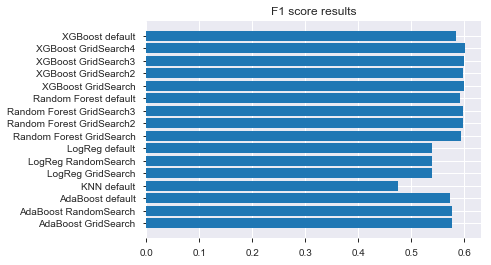

In [36]:
plot_results(model_results)